[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HUSTneeb/GoogleColabCode/blob/master/TensorFlowLearningPix2Pix.ipynb)

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output


In [2]:
path_to_zip=tf.keras.utils.get_file('facades.tar.gz',
                                   cache_subdir=os.path.abspath('.'),
                                   origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz',
                                   extract=True)
PATH=os.path.join(os.path.dirname(path_to_zip),'facades/')

30171136/30168306 [==============================] - 2s 0us/step


In [0]:
BUFFER_SIZE=400
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256

In [0]:
def load_image(image_file,is_train):
  image=tf.read_file(image_file)
  image=tf.image.decode_jpeg(image)
  
  w=tf.shape(image)[1]
  
  w=w//2
  real_image=image[:,:w,:]
  input_image=image[:,w:,:]
  
  input_image=tf.cast(input_image,tf.float32)
  real_image=tf.cast(real_image,tf.float32)
  
  if is_train:
    input_image=tf.image.resize_images(input_image,[286,286],
                                      align_corners=True,
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image=tf.image.resize_images(real_image,[286,286],
                                     align_corners=True,
                                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    stacked_image=tf.stack([input_image,real_image],axis=0)
    cropped_image=tf.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
    input_image,real_image=cropped_image[0],cropped_image[1]
    
    if np.random.random()>0.5:
      input_image=tf.image.flip_left_right(input_image)
      real_image=tf.image.flip_left_right(real_image)
    else:
      input_image=tf.image.resize_images(input_image,size=[IMG_HEIGHT,IMG_WIDTH],
                                        align_corners=True,method=2)
      real_image=tf.image.resize_images(real_image,size=[IMG_HEIGHT,IMG_WIDTH],
                                       align_corners=True,method=2)
      
  input_image=(input_image/127.5)-1
  real_image=(real_image/127.5)-1
  
  return input_image,real_image
  

In [0]:
train_dataset=tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.map(lambda x:load_image(x,True))
train_dataset=train_dataset.batch(1)

test_dataset=tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset=test_dataset.map(lambda x:load_image(x,False))
test_dataset=test_dataset.batch(1)

In [0]:
OUTPUT_CHANNELS=3

class Downsample(tf.keras.Model):
  def __init__(self,filters,size,apply_batchnorm=True):
    super(Downsample,self).__init__()
    self.apply_batchnorm=apply_batchnorm
    initializer=tf.random_normal_initializer(0.,0.02)
    
    self.conv1=tf.keras.layers.Conv2D(filters,
                                     (size,size),
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False)
    
    if self.apply_batchnorm:
      self.batchnorm=tf.keras.layers.BatchNormalization()
      
  def call(self,x,training):
    x=self.conv1(x)
    if self.apply_batchnorm:
      x=self.batchnorm(x,training=training)
      
    x=tf.nn.leaky_relu(x)
    return x
  
class Upsample(tf.keras.Model):
  def __init__(self,filters,size,apply_dropout=False):
    super(Upsample,self).__init__()
    self.apply_dropout=apply_dropout
    initializer=tf.random_normal_initializer(0.,0.02)
    
    self.up_conv=tf.keras.layers.Conv2DTranspose(filters,
                                                (size,size),
                                                strides=2,
                                                padding='same',
                                                kernel_initializer=initializer,
                                                use_bias=False)
    
    self.batchnorm=tf.keras.layers.BatchNormalization()
    if self.apply_dropout:
      self.dropout=tf.keras.layers.Dropout(0.5)
      
  def call(self,x1,x2,training):
    x=self.up_conv(x1)
    x=self.batchnorm(x,training=training)
    if self.apply_dropout:
      x=self.dropout(x,training=training)
    x=tf.nn.relu(x)
    x=tf.concat([x,x2],axis=-1)
    return x
  
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator,self).__init__()
    initializer=tf.random_normal_initializer(0.,0.02)
    
    self.down1=Downsample(64,4,apply_batchnorm=False)
    self.down2=Downsample(128,4)
    self.down3=Downsample(256,4)
    self.down4=Downsample(512,4)
    self.down5=Downsample(512,4)
    self.down6=Downsample(512,4)
    self.down7=Downsample(512,4)
    self.down8=Downsample(512,4)
    
    self.up1=Upsample(512,4,apply_dropout=True)
    self.up2=Upsample(512,4,apply_dropout=True)
    self.up3=Upsample(512,4,apply_dropout=True)
    self.up4=Upsample(512,4)
    self.up5=Upsample(256,4)
    self.up6=Upsample(128,4)
    self.up7=Upsample(64,4)
    
    self.last=tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                             (4,4),
                                             strides=2,
                                             padding='same',
                                             kernel_initializer=initializer)
    
  @tf.contrib.eager.defun
  def call(self,x,training):
      x1=self.down1(x,training=training)
      x2=self.down2(x1,training=training)
      x3=self.down3(x2,training=training)
      x4=self.down4(x3,training=training)
      
      x5=self.down5(x4,training=training)
      x6=self.down6(x5,training=training)
      x7=self.down7(x6,training=training)
      x8=self.down8(x7,training=training)
      
      x9=self.up1(x8,x7,training=training)
      x10=self.up2(x9,x6,training=training)
      x11=self.up3(x10,x5,training=training)
      x12=self.up4(x11,x4,training=training)
      
      x13=self.up5(x12,x3,training=training)
      x14=self.up6(x13,x2,training=training)
      x15=self.up7(x14,x1,training=training)
      
      x16=self.last(x15)
      x16=tf.nn.tanh(x16)
      
      return x16
    
    
class DiscDownsample(tf.keras.Model):
  
  def __init__(self,filters,size,apply_batchnorm=True):
    super(DiscDownsample,self).__init__()
    self.apply_batchnorm=apply_batchnorm
    initializer=tf.random_normal_initializer(0.,0.02)
    
    self.conv1=tf.keras.layers.Conv2D(filters,
                                     (size,size),
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False)
    if self.apply_batchnorm:
      self.batchnorm=tf.keras.layers.BatchNormalization()
      
  def call(self,x,training):
    x=self.conv1(x)
    if self.apply_batchnorm:
      x=self.batchnorm(x,training=training)
      
    x=tf.nn.leaky_relu(x)
    return x
  
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator,self).__init__()
    initializer=tf.random_normal_initializer(0.,0.02)
    
    self.down1=DiscDownsample(64,4,False)
    self.down2=DiscDownsample(128,4)
    self.down3=DiscDownsample(256,4)
    
    self.zero_pad1=tf.keras.layers.ZeroPadding2D()
    self.conv=tf.keras.layers.Conv2D(512,
                                    (4,4),
                                    strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)
    self.batchnorm1=tf.keras.layers.BatchNormalization()
    
    self.zero_pad2=tf.keras.layers.ZeroPadding2D()
    self.last=tf.keras.layers.Conv2D(1,
                                    (4,4),
                                    strides=1,
                                    kernel_initializer=initializer)
    
  @tf.contrib.eager.defun
  def call(self,inp,tar,training):
    x=tf.concat([inp,tar],axis=-1)
    x=self.down1(x,training=training)
    x=self.down2(x,training=training)
    x=self.down3(x,training=training)
    
    x=self.zero_pad1(x)
    x=self.conv(x)
    x=self.batchnorm1(x,training=training)
    x=tf.nn.leaky_relu(x)
    
    x=self.zero_pad2(x)
    x=self.last(x)
    
    return x


In [0]:
generator=Generator()
discriminator=Discriminator()

In [0]:
LAMBDA=100

In [0]:
def discriminator_loss(disc_real_output,disc_generated_output):
  real_loss=tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_real_output),
                                           logits=disc_real_output)
  generated_loss=tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(disc_generated_output),
                                                logits=disc_generated_output)
  total_disc_loss=real_loss+generated_loss
  
  return total_disc_loss

def generator_loss(disc_generated_output,gen_output,target):
  gan_loss=tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_generated_output),
                                          logits=disc_generated_output)
  l1_loss=tf.reduce_mean(tf.abs(target-gen_output))
  
  total_gen_loss=gan_loss+(LAMBDA*l1_loss)
  
  return total_gen_loss

In [0]:
generator_optimizer=tf.train.AdamOptimizer(2e-4,beta1=0.5)
discriminator_optimizer=tf.train.AdamOptimizer(2e-4,beta1=0.5)

In [0]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                              discriminator_optimizer=discriminator_optimizer,
                              generator=generator,
                              discriminator=discriminator)

In [0]:
EPOCHS=200

In [0]:
def generate_images(model,test_input,tar):
  prediction=model(test_input,training=True)
  plt.figure(figsize=(15,15))
  
  display_list=[test_input[0],tar[0],prediction[0]]
  title=['Input img','Ground img','Predicted img']
  
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    
    plt.imshow(display_list[i]*0.5+0.5)
    plt.axis('off')
    
  plt.show()
  
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()
    
    for input_image,target in dataset:
      with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        gen_output=generator(input_image,training=True)
        
        disc_real_output=discriminator(input_image,target,training=True)
        disc_generated_output=discriminator(input_image,gen_output,training=True)
        
        gen_loss=generator_loss(disc_generated_output,gen_output,target)
        disc_loss=discriminator_loss(disc_real_output,disc_generated_output)
        
      generator_gradients=gen_tape.gradient(gen_loss,generator.variables)
      
      discriminator_gradients=disc_tape.gradient(disc_loss,discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(generator_gradients,generator.variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                 discriminator.variables))
      if epoch %1 ==0:
        clear_output(wait=True)
        for inp,tar in test_dataset.take(1):
          generate_images(generator,inp,tar)
          
      if (epoch+1)%20 ==0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
      print(epoch+1,':',time.time()-start)

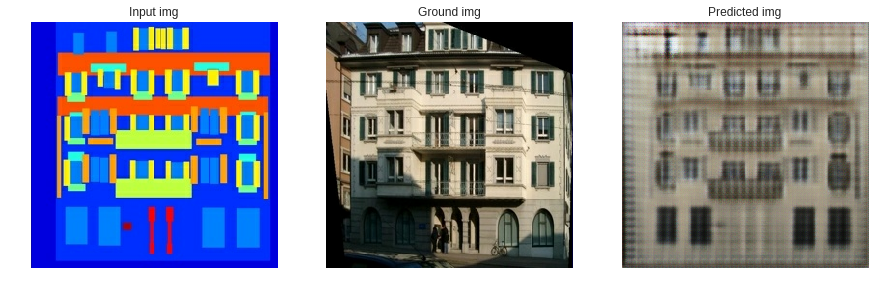

2 : 880.7625379562378


In [0]:
train(train_dataset,EPOCHS)